# Behavioral Profile Stratification via Unsupervised learning

### TODO

> Please report some description here about the pipeline and what I am going to find in the notebook

In [1]:


# THESE IMPORT ARE NOT NEEDED, APPARENTLY:

# import utils as ut
# import pandas as pd

Created directory /odf-data: 2019-07-11-16-44-13



## Step 1: Data Loading

> Short description here - and notes on Data Accessibility

In [ ]:
from dataset import access_db, demographics
#  from dataset import data_path  - COMMENTED as it is never used, apparently

In [2]:
subj_list, p_enc, df_dict = access_db()

In [3]:
demographics(subj_list, p_enc)

Period span: 01/05/2013 -- 31/10/2018

N of subjects: 205

Average number of assessments: 5.522
Median number of assessments: 5.0
Maximum number of assessments: 24
Minimum number of assessments: 1

Average number of encounters: 1.439
Median number of encounters: 1.0
Maximum number of encounters: 5
Minimum number of encounters: 1

Instrument list:
leiterinternationalperformancescale-revised
wppsi-iiifascia40-73
ados-2modulo2
wisc-iii
ados-2modulotoddler
griffithsmentaldevelopmentscales
wisc-iv
psi-sf
emotionalavailabilityscales
wppsi-iiifascia26-311
wais-iv
ados-2modulo3
wppsi
ados-2modulo1
srs
vineland-ii
N of selected instruments: 16


Mean age of the subjects: 11.06242645005148 -- Standard deviation: 5.097775697784719
N Female: 34 -- N Male: 171



## Step 2: Feature Processing

> Short description here

In [ ]:
from features import (create_tokens, behr_level4, 
                      create_vocabulary, create_features_data)

# SIDENOTE: I am not a huge fan of import * - so let's make it crystal clear

In [4]:
raw_behr = create_tokens(df_dict)

Average length of behavioral sequences: 5.488



In [5]:
lev4 = behr_level4(raw_behr)

In [6]:
lab4_to_idx, idx_to_lab4 = create_vocabulary(lev4, level=4)
out_behr_lev4 = create_behr(lev4, lab4_to_idx, level=4)

Vocabulary size:1167



In [7]:
feat_df, feat_scaled_df = create_features_data(lev4)

---

## Step 3: Embeddings

> Short description here

In [ ]:
from pt_embedding import Pembeddings

In [8]:
model = Pembeddings(out_behr_lev4, idx_to_lab4)

In [9]:
svd_pid_list_l4, svd_mtx_l4 = model.tfidf()
glove_pid_list_l4, glove_emb_l4 = model.glove_pemb()

Performing SVD on the TF-IDF matrix...

Training Glove embeddings...
epoch 0, error 0.010
epoch 10, error 0.007
epoch 20, error 0.006
epoch 30, error 0.005
epoch 40, error 0.005
epoch 50, error 0.005
epoch 60, error 0.005
epoch 70, error 0.005
epoch 80, error 0.005
epoch 90, error 0.005


---

## Step 4: Clustering

> Short description here

In [ ]:
from clustering import HclustEmbeddings, HclustFeatures

In [10]:
hclust_emb = HclustEmbeddings(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                              affinity='euclidean', linkage='ward')

### `TF-IDF` Embedding

In [11]:
# TFIDF EMBEDDING
tfidf_best_cl = hclust_emb.find_best_nclu(svd_mtx_l4, n_iter=ut.n_iter, 
                                          subsampl=ut.subsampl)

(*) Iter 0 -- N clusters 4
Counts of N clusters:
N clusters -- Count
4 1

Best N cluster:4


In [12]:
tfidf_subc = hclust_emb.fit(svd_mtx_l4, svd_pid_list_l4, tfidf_best_cl)

(*) Number of clusters 4 -- Silhouette score 0.34
Cluster 0 -- Numerosity 177
Cluster 1 -- Numerosity 15
Cluster 2 -- Numerosity 7
Cluster 3 -- Numerosity 4






### `Glove` Embedding

In [13]:
# GLOVE EMBEDDING
glv_best_cl = hclust_emb.find_best_nclu(glove_emb_l4, n_iter=ut.n_iter, subsampl=ut.subsampl)

(*) Iter 0 -- N clusters 3
Counts of N clusters:
N clusters -- Count
3 1

Best N cluster:3


In [14]:
glv_subc = hclust_emb.fit(glove_emb_l4, glove_pid_list_l4, glv_best_cl)

(*) Number of clusters 3 -- Silhouette score 0.47
Cluster 0 -- Numerosity 117
Cluster 1 -- Numerosity 71
Cluster 2 -- Numerosity 15






### Clustering and Feature Representation

> Short description here

In [15]:
hclust_feat = HclustFeatures(min_cl=ut.min_cl, max_cl=ut.max_cl, 
                             affinity='euclidean', linkage='ward')

In [16]:
# FEATURES REPRESENTATION
feat_best_cl = hclust_feat.find_best_nclu(feat_scaled_df, n_iter=ut.n_iter, subsampl=ut.subsampl)

(*) Iter 0 -- N clusters 3
Counts of N clusters:
N clusters -- Count
3 1

Best N cluster:3


In [17]:
feat_subc = hclust_feat.fit(feat_scaled_df, feat_best_cl)

(*) Number of clusters 3 -- Silhouette score 0.24
Cluster 0 -- Numerosity 177
Cluster 1 -- Numerosity 1
Cluster 2 -- Numerosity 25






## Step 5: Visualisation 

> Short description here

In [ ]:
from bokeh.plotting import figure, ColumnDataSource, show, output_notebook
from bokeh.models import CategoricalColorMapper, HoverTool
from bokeh.models import (LinearColorMapper, BasicTicker, PrintfTickFormatter, 
                          ColorBar, HoverTool, ColumnDataSource)
from bokeh.plotting import figure, output_file, output_noteboook, save, show
from bokeh.resources import CDN

output_notebook(CDN)

In [ ]:
from visualization import Visualization

In [18]:
viz = Visualization(p_enc, ut.col_dict, ut.c_out)

Loading BokehJS ...

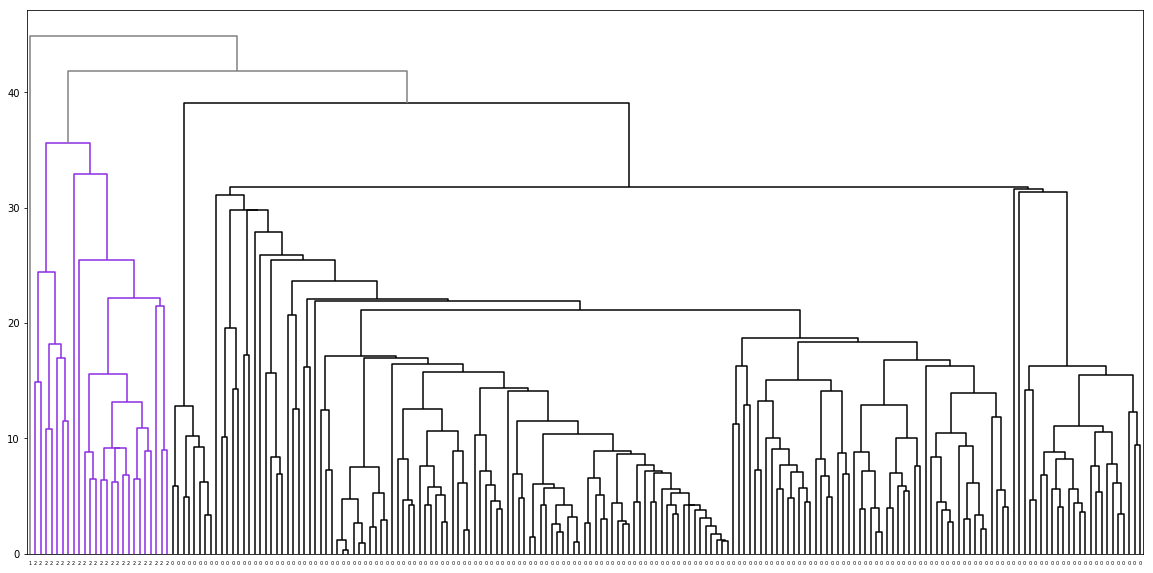

In [19]:
viz.scatterplot_dendrogram(feat_scaled_df, feat_subc, 20, 10)

**TODO**: HEAT-Maps are not rendered

In [20]:
viz.heatmap_feat(feat_df, feat_scaled_df, feat_subc, 1000, 1800)

Loading BokehJS ...

Loading BokehJS ...

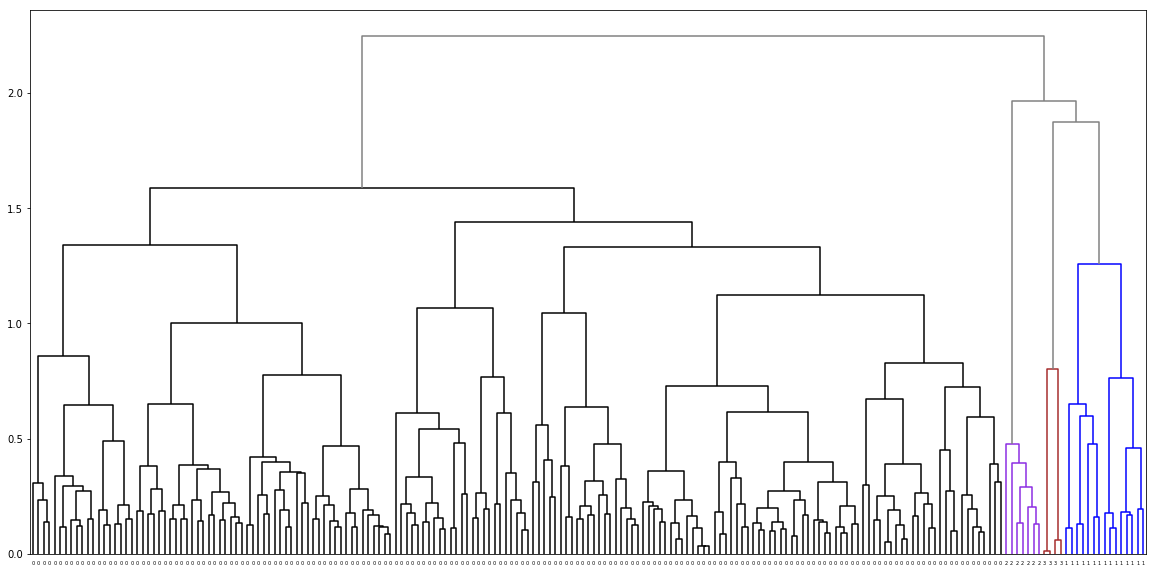

In [21]:
viz.scatterplot_dendrogram(svd_mtx_l4, tfidf_subc, 20, 10)

In [22]:
viz.heatmap_emb(out_behr_lev4, idx_to_lab4, tfidf_subc, 500, 2000)

Loading BokehJS ...

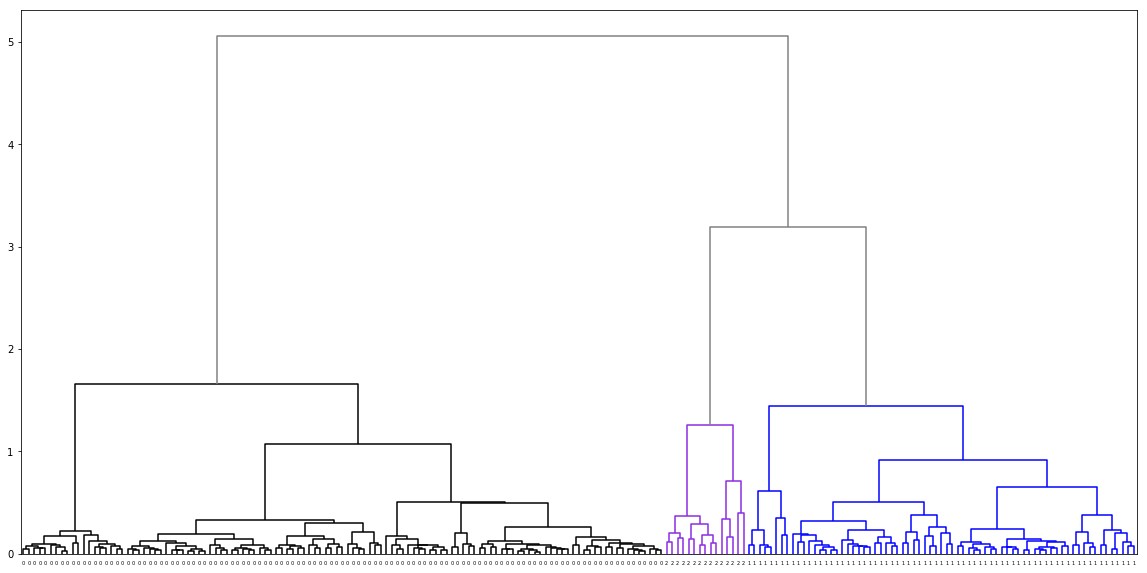

In [23]:
viz.scatterplot_dendrogram(glove_emb_l4, glv_subc, 20, 10)

In [24]:
viz.heatmap_emb(out_behr_lev4, idx_to_lab4, glv_subc, 500, 2000)